In [1]:
import sys
from pathlib import Path

In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

# Xử lý dữ liệu

## Lấy dữ liệu

Lấy dữ liệu từ file CSV

In [3]:
# Lấy dữ liệu từ nguồn sẵn có
import sys
import os
import talib as ta
sys.path.append('d:\\NCKH\\SARSA_FinancialRL')  # Thêm đường dẫn gốc để import module

import pandas as pd
from data.data_processor.feature_engineer import engineer_stat as es
from data.split_data.split import split_data_two_parts
from environments.stock_trading_env.mdp import StockTradingMDP as stockMDP
from agents.d_sarsa.d_sarsa import train_deep_sarsa

# Định nghĩa đường dẫn gốc
base_path = 'd:\\NCKH\\SARSA_FinancialRL'

# Lấy dữ liệu tạm từ nguồn sẵn có
csv_path = os.path.join(base_path, 'data', 'data_storer', 'data_research', 'HPG_data.csv')
df = pd.read_csv(csv_path)
df

,time,open,high,low,close,volume
0,20/06/2012,1.03,1.04,1.03,1.03,82290
1,21/06/2012,1.01,1.03,1.01,1.03,78090
2,22/06/2012,1.02,1.03,1.02,1.03,79400
3,25/06/2012,1.03,1.03,1.02,1.03,131080
4,26/06/2012,1.01,1.02,1.01,1.02,126200
...,...,...,...,...,...,...
3128,25/12/2024,22.29,22.62,22.29,22.62,17153771
3129,26/12/2024,22.62,22.67,22.37,22.50,9982189
3130,27/12/2024,22.50,22.50,22.33,22.37,11397592
3131,30/12/2024,22.33,22.37,22.21,22.29,12176491


## Tính toán các chỉ báo kĩ thuật

In [4]:
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time').reset_index(drop=True)

# Gọi hàm với start_date và config tùy chỉnh
start_date = pd.to_datetime('01-01-2013', format='%d-%m-%Y')
price_history = es.add_technical_indicators(
    df, 
    start_date=start_date
)
# df_with_indicators giờ đã có các cột chỉ số, gắn vào df gốc của bạn
price_history

C:\Users\Admin\AppData\Local\Temp\ipykernel_26720\1549584949.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['time'] = pd.to_datetime(df['time'])


,time,open,high,low,close,volume,MACD,RSI,CCI,ADX
0,02/01/2013,1.12,1.13,1.11,1.12,541540,0.033967,65.651683,133.838384,30.660577
1,03/01/2013,1.12,1.13,1.11,1.13,720080,0.034780,67.171896,122.897357,31.450804
2,04/01/2013,1.14,1.19,1.13,1.17,569620,0.038211,72.428490,173.722170,33.306400
3,07/01/2013,1.13,1.23,1.13,1.23,926020,0.045250,78.094607,196.341293,35.522421
4,08/01/2013,1.28,1.29,1.26,1.28,1480180,0.054238,81.505520,257.126236,38.108911
...,...,...,...,...,...,...,...,...,...,...
2991,25/12/2024,22.29,22.62,22.29,22.62,17153771,0.056668,52.567076,-22.058258,16.048225
2992,26/12/2024,22.62,22.67,22.37,22.50,9982189,0.050150,50.535352,-28.125768,15.912502
2993,27/12/2024,22.50,22.50,22.33,22.37,11397592,0.034101,48.354940,-60.925973,15.621869
2994,30/12/2024,22.33,22.37,22.21,22.29,12176491,0.014757,47.010717,-84.969757,14.862839


## Chia dữ liệu

In [5]:
# Chia dữ liệu theo khoảng thời gian cụ thể
price_history['time'] = pd.to_datetime(price_history['time'], format='%d/%m/%Y')

# Good period
good_train_HPG = price_history[(price_history['time'] >= '2013-01-01') & (price_history['time'] <= '2018-12-31')]
good_test_HPG = price_history[(price_history['time'] >= '2019-01-01') & (price_history['time'] <= '2021-12-31')]

# Bad period
bad_train_HPG = price_history[(price_history['time'] >= '2013-01-01') & (price_history['time'] <= '2021-12-31')]
bad_test_HPG = price_history[(price_history['time'] >= '2022-01-01') & (price_history['time'] <= '2023-12-31')]

print(f"Good Train HPG: {len(good_train_HPG)} rows")
good_train_HPG
print(f"Good Test HPG: {len(good_test_HPG)} rows")
good_test_HPG
print(f"Bad Train HPG: {len(bad_train_HPG)} rows")
bad_train_HPG
print(f"Bad Test HPG: {len(bad_test_HPG)} rows")
bad_test_HPG




Good Train HPG: 1496 rows
Good Test HPG: 752 rows
Bad Train HPG: 2248 rows
Bad Test HPG: 498 rows


,time,open,high,low,close,volume,MACD,RSI,CCI,ADX
2248,2022-01-04,26.83,27.06,26.72,26.80,20100700,-0.565777,45.550621,27.225506,30.678471
2249,2022-01-05,26.89,27.15,26.83,26.83,18760700,-0.500479,45.963412,41.610376,28.991851
2250,2022-01-06,26.66,26.77,26.43,26.43,17172700,-0.475525,41.451122,-24.640400,28.079455
2251,2022-01-07,26.43,26.49,26.17,26.26,16335300,-0.464116,39.668716,-62.769038,27.618181
2252,2022-01-10,26.29,26.75,26.09,26.17,17477500,-0.457068,38.719472,-52.410123,26.625678
...,...,...,...,...,...,...,...,...,...,...
2741,2023-12-25,20.57,20.91,20.57,20.79,20414974,0.157600,55.944903,40.875912,14.095142
2742,2023-12-26,20.76,21.14,20.76,21.06,33753533,0.183383,59.460872,98.654481,14.647102
2743,2023-12-27,21.10,21.21,21.02,21.02,19860170,0.198303,58.713277,115.260144,15.310545
2744,2023-12-28,21.02,21.36,20.95,21.17,31321948,0.219699,60.708317,126.289308,16.245551


In [6]:
# Lưu các biến DataFrame thành file CSV
import os

# Thư mục train
train_dir = r'D:\nckh\SARSA_FinancialRL\data\data_storer\data_research\train'
os.makedirs(train_dir, exist_ok=True)
good_train_HPG.to_csv(os.path.join(train_dir, 'good_train_HPG.csv'), index=False)
bad_train_HPG.to_csv(os.path.join(train_dir, 'bad_train_HPG.csv'), index=False)

# Thư mục test
test_dir = r'D:\nckh\SARSA_FinancialRL\data\data_storer\data_research\test'
os.makedirs(test_dir, exist_ok=True)
good_test_HPG.to_csv(os.path.join(test_dir, 'good_test_HPG.csv'), index=False)
bad_test_HPG.to_csv(os.path.join(test_dir, 'bad_test_HPG.csv'), index=False)

print("Đã lưu tất cả file CSV thành công!")


Đã lưu tất cả file CSV thành công!


# Triển khai chính sách ngẫu nhiên
làm tiên chuẩn (baseline) để so sánh với kết quả với kết quả của ba agent sắp tới.

Chính sách này không học hỏi gì, chỉ chọn hành động ngẫu nhiên đều đặn, như tung xúc xắc để quyết định mua/bán.

Chạy trên tập test

In [7]:
train = good_train_HPG
test = good_test_HPG
# Định nghĩa danh sách hành động (A) - cần thiết cho pi_random
balance_init = 1000  # số dư ban đầu
k = 5  # số cổ phiếu tối đa
min_balance = -100  # ngưỡng số dư tối thiểu
A = [a for a in range(-k, k + 1, 1)]  # hành động: -5 đến +5

# Tạo instance của StockTradingMDP
mdp = stockMDP(balance_init=balance_init, k=k, min_balance=min_balance)

# policy
def pi_random(s, greedy=False, eps=0.2):
    return np.random.choice(A) # random policy (uniform distributed)

profits = list()
for rep in tqdm(range(20)):
    profit = mdp.interact_test(
        pi=pi_random,  # chính sách (hàm pi_random)
        train_series=train,  # DataFrame train (từ cell chia dữ liệu)
        test_series=test,  # DataFrame test (từ cell chia dữ liệu)
        series_name='test',  # chạy trên tập test
        verbose=False  # không hiển thị biểu đồ (chỉ thu thập dữ liệu)
    )
    profits.append(profit)
print("Avg Profit", np.mean(profits))
print('STD Profit', np.std(profits))

100%|██████████| 20/20 [00:01<00:00, 12.78it/s]

Avg Profit 624.250382
STD Profit 439.4562139971565


In [8]:
good_train_HPG

,time,open,high,low,close,volume,MACD,RSI,CCI,ADX
0,2013-01-02,1.12,1.13,1.11,1.12,541540,0.033967,65.651683,133.838384,30.660577
1,2013-01-03,1.12,1.13,1.11,1.13,720080,0.034780,67.171896,122.897357,31.450804
2,2013-01-04,1.14,1.19,1.13,1.17,569620,0.038211,72.428490,173.722170,33.306400
3,2013-01-07,1.13,1.23,1.13,1.23,926020,0.045250,78.094607,196.341293,35.522421
4,2013-01-08,1.28,1.29,1.26,1.28,1480180,0.054238,81.505520,257.126236,38.108911
...,...,...,...,...,...,...,...,...,...,...
1491,2018-12-24,7.94,8.09,7.94,8.09,3262070,-0.450539,29.131147,-125.586104,44.347578
1492,2018-12-25,7.86,8.06,7.68,8.06,4800740,-0.448038,28.700047,-120.187932,45.598118
1493,2018-12-26,8.06,8.06,7.89,8.04,3827010,-0.442569,28.398325,-96.178022,46.759335
1494,2018-12-27,8.18,8.25,8.04,8.21,4873610,-0.419679,34.683934,-63.596188,46.752601


In [9]:
good_test_HPG

,time,open,high,low,close,volume,MACD,RSI,CCI,ADX
1496,2019-01-02,8.20,8.34,8.17,8.17,4196210,-0.377831,33.872503,-43.597666,46.014442
1497,2019-01-03,8.16,8.20,7.82,7.82,6877510,-0.386458,27.754038,-74.856830,46.093789
1498,2019-01-04,7.80,7.96,7.61,7.88,5841290,-0.384025,30.085510,-86.718483,46.535977
1499,2019-01-07,8.04,8.05,7.73,7.78,2488920,-0.385721,28.438283,-77.049267,46.477839
1500,2019-01-08,7.80,7.82,7.61,7.65,3150620,-0.393024,26.413623,-99.558586,46.649772
...,...,...,...,...,...,...,...,...,...,...
2243,2021-12-27,26.69,26.72,26.11,26.32,10675000,-0.790765,38.046591,-81.527814,35.582105
2244,2021-12-28,26.32,26.77,26.14,26.26,12356700,-0.760894,37.575948,-75.274475,34.748545
2245,2021-12-29,26.26,26.54,26.09,26.26,15118200,-0.728820,37.575948,-81.083806,34.034222
2246,2021-12-30,26.54,26.54,26.20,26.20,10285000,-0.700171,37.044490,-71.993943,33.370921


# Huấn luyện agent Deep - SARSA với tình huống tốt


In [10]:
"""
shared_config = {
    'episodes': 30,         # Original episodes
    'gamma': 0.6,          # Original gamma
    'alpha': 0.7,           # Original alpha
    'epsilon_start': 0.8,   # Original epsilon_start
    'epsilon_min': 0.2,     # Original epsilon_min
    'epsilon_decay': 0.9,  # Chỉnh nhẹ từ 0.98 xuống 0.95 để khám phá chậm hơn trên FPT
    'nn_epochs': 10,        # Original nn_epochs
    'nn_lr': 1e-5,          # Original nn_lr
    'enabled_agents': [1, 1,1]  # [SARSA, DQN, PG]: 1 để bật, 0 để tắt
}
"""
shared_config = {
    'episodes': 35,         # Original episodes
    'gamma': 0.95,          # Original gamma
    'alpha': 0.6,           # Original alpha
    'epsilon_start': 0.9,   # Original epsilon_start
    'epsilon_min': 0.1,     # Original epsilon_min
    'epsilon_decay': 0.95,  # Chỉnh nhẹ từ 0.98 xuống 0.95 để khám phá chậm hơn trên FPT
    'nn_epochs': 10,        # Original nn_epochs
    'nn_lr': 1e-5,          # Original nn_lr
    'enabled_agents': [1, 1,1]  # [SARSA, DQN, PG]: 1 để bật, 0 để tắt
}


"""'episodes': 35, 'gamma': 0.8369349814523732, 'alpha': 0.5680671593345815, 'epsilon_start': 0.9540941536350933, 'epsilon_min': 0.19785221090168595, 'epsilon_decay': 0.9489652036913004, 'nn_epochs': 32, 'nn_lr': 0.0002990739041169814}"""

"'episodes': 35, 'gamma': 0.8369349814523732, 'alpha': 0.5680671593345815, 'epsilon_start': 0.9540941536350933, 'epsilon_min': 0.19785221090168595, 'epsilon_decay': 0.9489652036913004, 'nn_epochs': 32, 'nn_lr': 0.0002990739041169814}"


RUNNING DEEP SARSA EXPERIMENTS


Running Deep SARSA 20 times:   0%|          | 0/20 [00:00<?, ?it/s]

Running Deep SARSA 20 times: 100%|██████████| 20/20 [10:15<00:00, 30.78s/it]



RUNNING DQN EXPERIMENTS


Running DQN 20 times: 100%|██████████| 20/20 [05:27<00:00, 16.38s/it]



RUNNING POLICY GRADIENT EXPERIMENTS


Running Policy Gradient 20 times: 100%|██████████| 20/20 [12:44<00:00, 38.20s/it]




EXPERIMENT SUMMARY

Deep SARSA:
  • Average Final Profit: $1271.82 ± $899.75
  • ROI: 127.18%
  • Annual Return Rate: 10.80%
  • Best Training Profit: $1298.49
  • Training Stability (std): $913.21

DQN:
  • Average Final Profit: $973.63 ± $990.05
  • ROI: 97.36%
  • Annual Return Rate: 8.87%
  • Best Training Profit: $992.08
  • Training Stability (std): $1012.76

Policy Gradient:
  • Average Final Profit: $799.92 ± $1127.57
  • ROI: 79.99%
  • Annual Return Rate: 7.62%


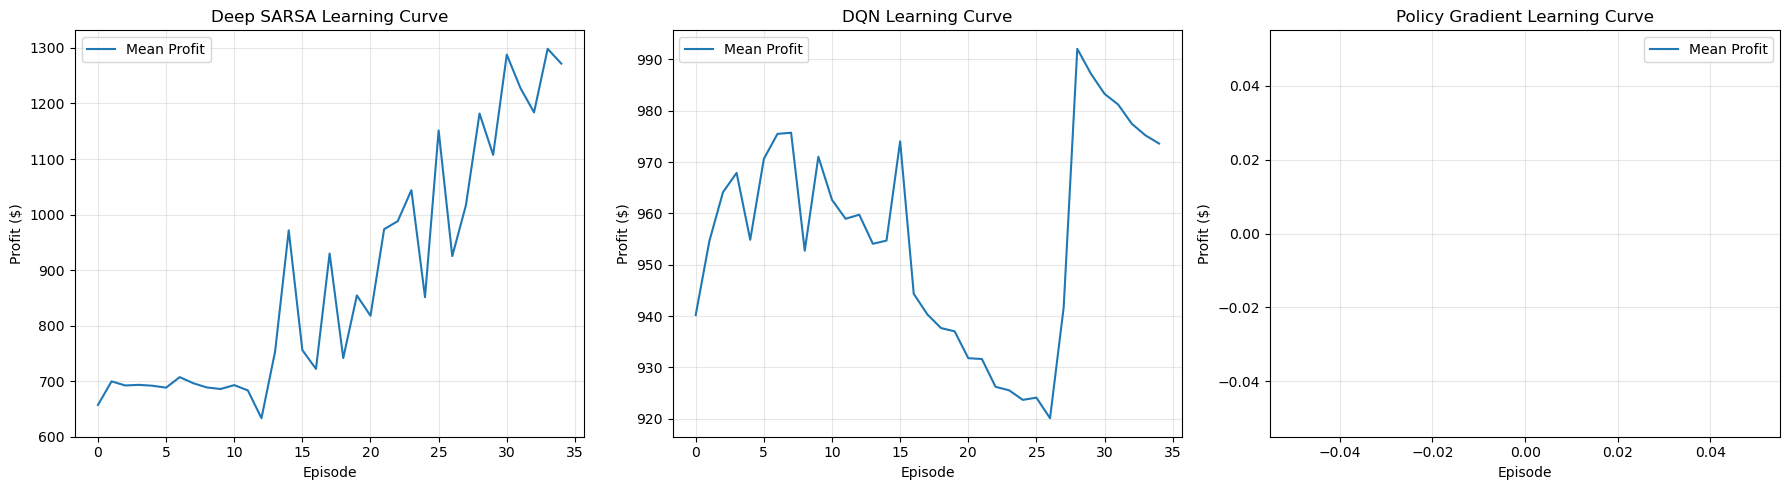


FINAL RESULTS SUMMARY

Deep SARSA:
  • Average Final Profit: $1271.82 ± $899.75
  • Best Profit: $2543.45
  • Worst Profit: $0.00
  • Peak Training Profit: $1298.49
  • ROI: 127.18%
  • Annual Return Rate: 31.52%
  • Total Return Rate: 127.18%

DQN:
  • Average Final Profit: $973.63 ± $990.05
  • Best Profit: $2378.01
  • Worst Profit: $0.00
  • Peak Training Profit: $992.08
  • ROI: 97.36%
  • Annual Return Rate: 25.48%
  • Total Return Rate: 97.36%

Policy Gradient:
  • Average Final Profit: $799.92 ± $1127.57
  • Best Profit: $2703.72
  • Worst Profit: $-70.84
  • ROI: 79.99%
  • Annual Return Rate: 21.68%
  • Total Return Rate: 79.99%

Random Policy Baseline:
  • Average Profit: $624.25 ± $439.46
  • Annual Return Rate: 17.58%
  • Total Return Rate: 62.43%


In [11]:
# Thêm đường dẫn gốc để import module
import sys
sys.path.append('d:\\NCKH\\SARSA_FinancialRL')

# Import run_experiments từ agents.run
from agents.run import run_experiments

# Định nghĩa shared_config với original settings từ paper, chỉnh nhẹ epsilon_decay xuống 0.95 để phù hợp với FPT data


# Chuyển lại Good Period
train = good_train_HPG
test = good_test_HPG

# Chạy thử nghiệm cho agent được bật với cùng siêu tham số
results = run_experiments(mdp, train, test, shared_config, num_runs=20)
results_good = results.copy()

# Hiển thị kết quả
import matplotlib.pyplot as plt

# Vẽ learning curves cho từng agent
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

agents = ['sarsa', 'dqn', 'pg']
titles = ['Deep SARSA', 'DQN', 'Policy Gradient']

for i, (agent, title) in enumerate(zip(agents, titles)):
    if agent in results:
        res = results[agent]
        mean_curve = res['learning_curve']
        
        axes[i].plot(mean_curve, label='Mean Profit')
        axes[i].set_title(f'{title} Learning Curve')
        axes[i].set_xlabel('Episode')
        axes[i].set_ylabel('Profit ($)')
        axes[i].legend()
        axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Định nghĩa hàm tính Annual Return Rate
def agent_annual_return(initial_capital, final_portfolio, start_date, end_date):
    total_return = (final_portfolio / initial_capital) - 1
    years = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days / 365.25
    if years <= 0: return 0, 0
    annual = (1 + total_return) ** (1 / years) - 1
    return annual * 100, total_return * 100

# Xác định start_date và end_date từ test_series
start_date = test.iloc[0]['time']
end_date = test.iloc[-1]['time']

# In tóm tắt kết quả
print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)

for agent in agents:
    if agent in results:
        res = results[agent]
        print(f"\n{res['agent']}:")
        print(f"  • Average Final Profit: ${res['final_profit']:.2f} ± ${res['std_final_profit']:.2f}")
        print(f"  • Best Profit: ${np.max(res['all_final_profits']):.2f}")
        print(f"  • Worst Profit: ${np.min(res['all_final_profits']):.2f}")
        if len(res['learning_curve']) > 0:
            print(f"  • Peak Training Profit: ${np.max(res['learning_curve']):.2f}")
        
        print(f"  • ROI: {res['roi']:.2f}%")
        
        # Tính Annual Return Rate
        final_portfolio = 1000 + res['final_profit']
        annual_rate, total_rate = agent_annual_return(1000, final_portfolio, start_date, end_date)
        print(f"  • Annual Return Rate: {annual_rate:.2f}%")
        print(f"  • Total Return Rate: {total_rate:.2f}%")

# So sánh với baseline (random policy)
print(f"\nRandom Policy Baseline:")
print(f"  • Average Profit: ${np.mean(profits):.2f} ± ${np.std(profits):.2f}")

# Tính Annual Return Rate cho baseline
baseline_final_portfolio = 1000 + np.mean(profits)
baseline_annual_rate, baseline_total_rate = agent_annual_return(1000, baseline_final_portfolio, start_date, end_date)
print(f"  • Annual Return Rate: {baseline_annual_rate:.2f}%")
print(f"  • Total Return Rate: {baseline_total_rate:.2f}%")

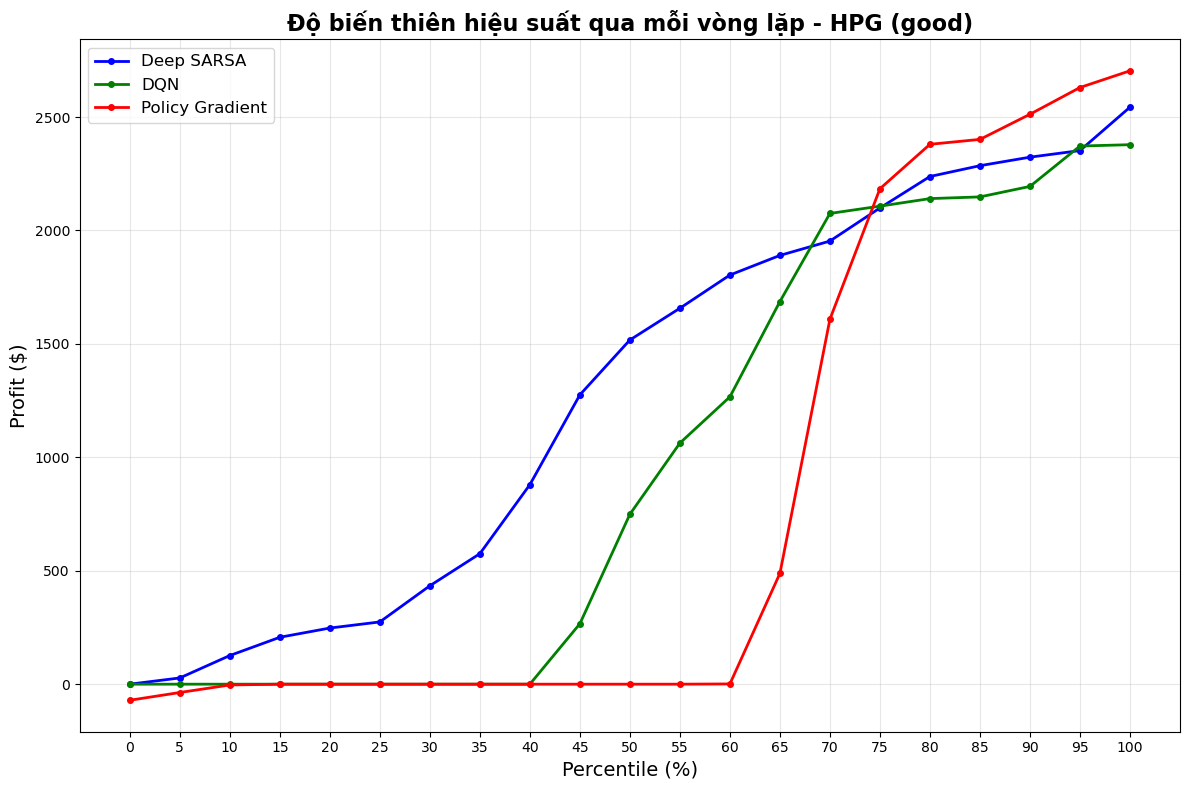

In [12]:
# Vẽ biểu đồ Percentiles Over Repeated Experiments
import matplotlib.pyplot as plt
import numpy as np

# Danh sách percentiles để vẽ (từ 0% đến 100% với bước 5%)
percentile_levels = np.arange(0, 101, 5)

# Tạo figure
plt.figure(figsize=(12, 8))

# Vẽ cho từng agent
colors = ['blue', 'green', 'red']
agents = ['sarsa', 'dqn', 'pg']
agent_names = ['Deep SARSA', 'DQN', 'Policy Gradient']

for i, (agent, name) in enumerate(zip(agents, agent_names)):
    if agent in results:
        profits = results[agent]['all_final_profits']
        sorted_profits = np.sort(profits)
        percentile_values = np.percentile(sorted_profits, percentile_levels)
        plt.plot(percentile_levels, percentile_values, 
                color=colors[i], marker='o', linestyle='-', 
                label=name, linewidth=2, markersize=4)

# Thiết lập biểu đồ
plt.title('Độ biến thiên hiệu suất qua mỗi vòng lặp - HPG (good)', fontsize=16, fontweight='bold')
plt.xlabel('Percentile (%)', fontsize=14)
plt.ylabel('Profit ($)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(percentile_levels)
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

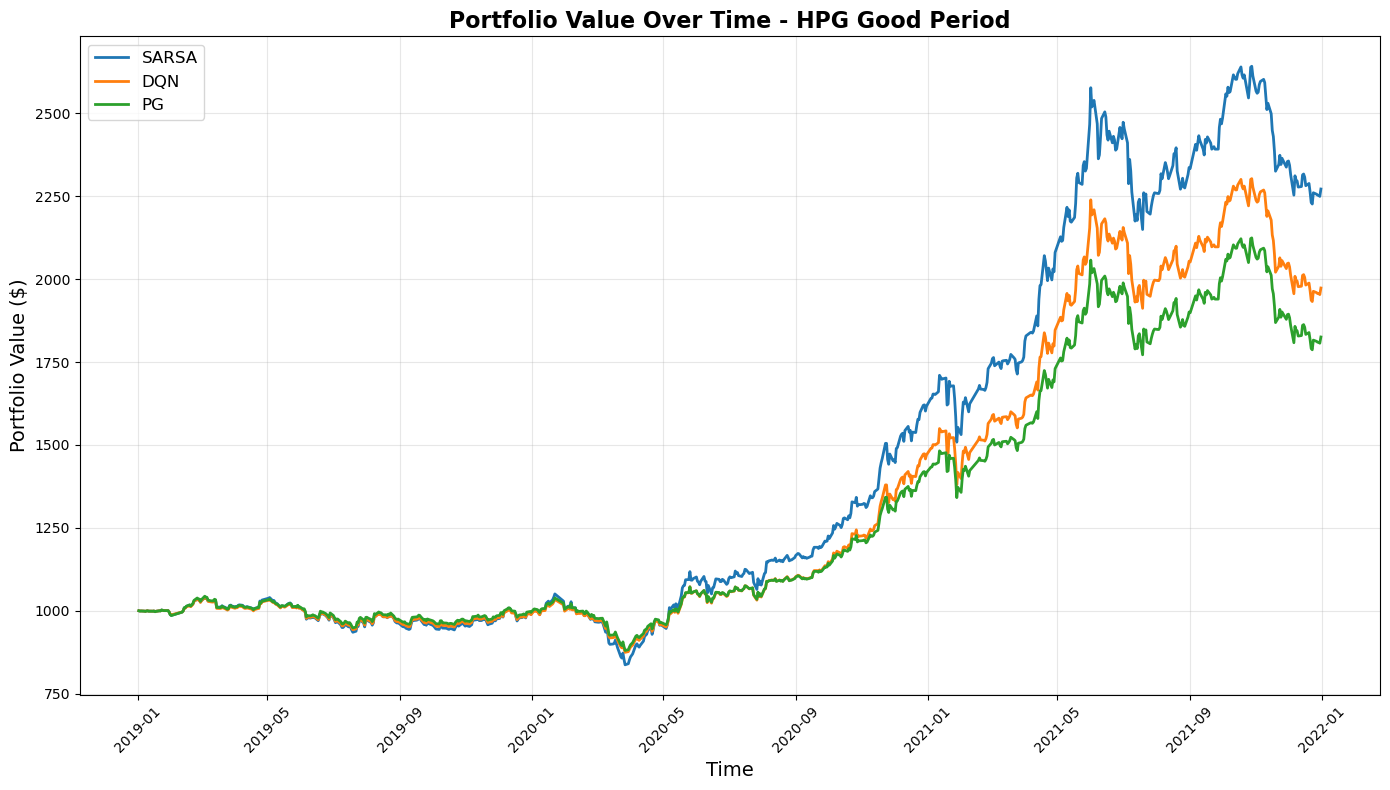

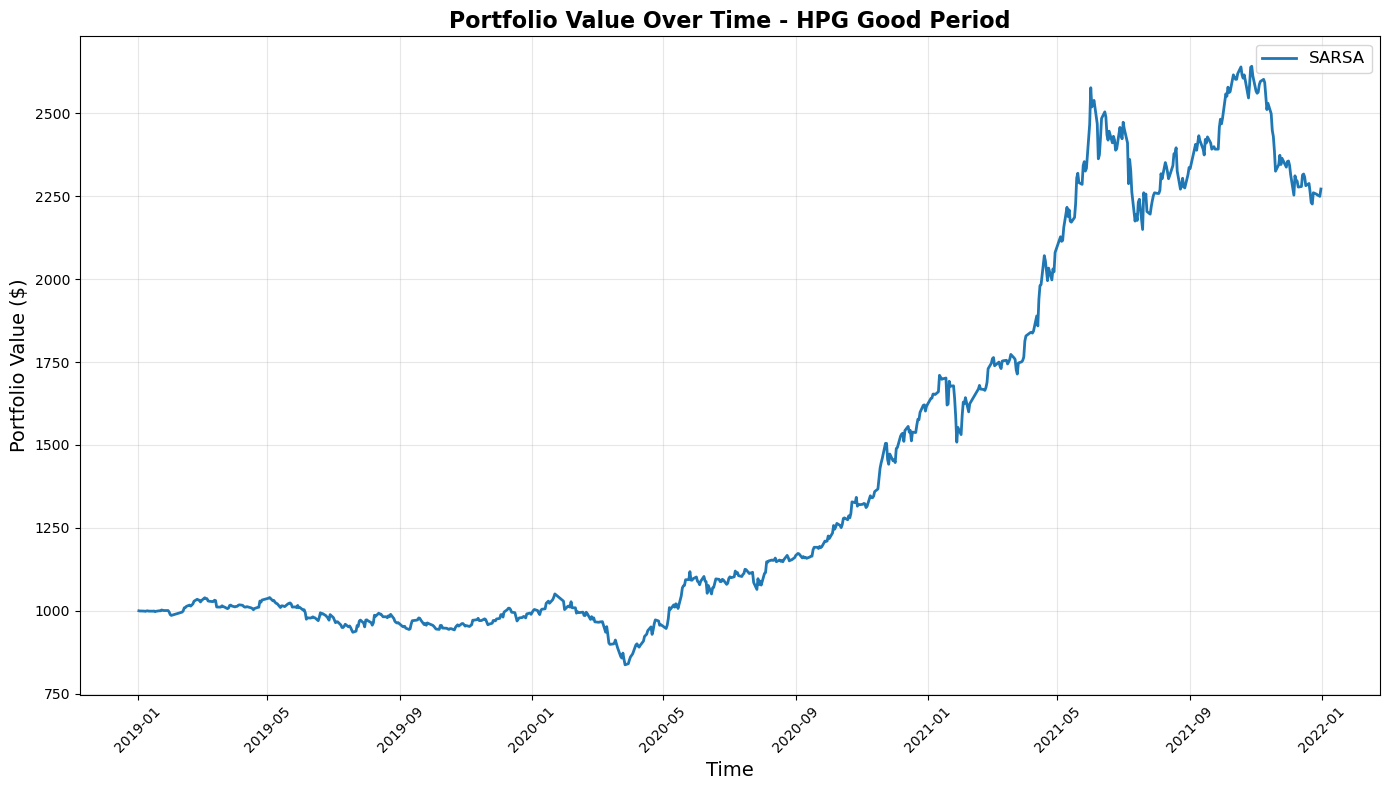

In [13]:
# Vẽ đồ thị
portfolio_histories = {}
for agent_name in ['sarsa', 'dqn', 'pg']:
    if agent_name in results:
        portfolio_histories[agent_name] = results[agent_name]['portfolio_history']

plt.figure(figsize=(14, 8))
for agent, port in portfolio_histories.items():
    # Cắt portfolio_history để khớp với len(test['time'])
    plt.plot(test['time'], port[1:], label=agent.upper(), linewidth=2)

plt.title('Portfolio Value Over Time - HPG Good Period', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Portfolio Value ($)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Vẽ đồ thị
portfolio_histories = {}
for agent_name in ['sarsa']:
    if agent_name in results:
        portfolio_histories[agent_name] = results[agent_name]['portfolio_history']

plt.figure(figsize=(14, 8))
for agent, port in portfolio_histories.items():
    # Cắt portfolio_history để khớp với len(test['time'])
    plt.plot(test['time'], port[1:], label=agent.upper(), linewidth=2)

plt.title('Portfolio Value Over Time - HPG Good Period', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Portfolio Value ($)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
import os

models_dir = r'D:\nckh\SARSA_FinancialRL\models'

os.makedirs(models_dir, exist_ok=True)

# Save trained models for ACB good period
if 'sarsa' in results:
    torch.save(results['sarsa']['trained_agent'].state_dict(), os.path.join(models_dir, 'sarsa_good_HPG.pth'))
    print("Deep SARSA model saved.")

if 'dqn' in results:
    results['dqn']['trained_agent'].save(os.path.join(models_dir, 'dqn_good_HPG.pth'))
    print("DQN model saved.")

if 'pg' in results:
    results['pg']['trained_agent'].save_model(os.path.join(models_dir, 'pg_good_HPG.pth'))
    print("Policy Gradient model saved.")

print("All models for HPG good period saved successfully!")

Deep SARSA model saved.
DQN model saved.
Policy Gradient model saved.
All models for HPG good period saved successfully!


In [15]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.lib import colors
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Spacer, Image
from reportlab.lib.styles import getSampleStyleSheet
import os

# Đảm bảo thư mục tồn tại
results_dir = r'D:\nckh\SARSA_FinancialRL\application\results'
os.makedirs(results_dir, exist_ok=True)

# Tạo PDF
pdf_path = os.path.join(results_dir, 'HPG_good.pdf')
doc = SimpleDocTemplate(pdf_path, pagesize=letter)
elements = []
styles = getSampleStyleSheet()

# Title
elements.append(Paragraph("Training Results for HPG Good Period", styles['Title']))
elements.append(Spacer(1, 12))

# Hyperparameters
elements.append(Paragraph("Hyperparameters:", styles['Heading2']))
hp_text = f"""
Episodes: {shared_config['episodes']}
Gamma: {shared_config['gamma']}
Alpha: {shared_config['alpha']}
Epsilon Start: {shared_config['epsilon_start']}
Epsilon Min: {shared_config['epsilon_min']}
Epsilon Decay: {shared_config['epsilon_decay']}
NN Epochs: {shared_config['nn_epochs']}
NN LR: {shared_config['nn_lr']}
Enabled Agents: {shared_config['enabled_agents']}
"""
elements.append(Paragraph(hp_text, styles['Normal']))
elements.append(Spacer(1, 12))

# Results Table
elements.append(Paragraph("Training Results:", styles['Heading2']))

# Tạo data cho table
data = [['Agent', 'Average Final Profit', 'Best Profit', 'Worst Profit', 'Peak Training Profit', 'ROI', 'Annual Return Rate', 'Total Return Rate']]
for agent in agents:
    if agent in results:
        res = results[agent]
        avg_profit = f"${res['final_profit']:.2f} ± ${res['std_final_profit']:.2f}"
        best = f"${np.max(res['all_final_profits']):.2f}"
        worst = f"${np.min(res['all_final_profits']):.2f}"
        peak = f"${np.max(res['learning_curve']):.2f}" if len(res['learning_curve']) > 0 else 'N/A'
        roi = f"{res['roi']:.2f}%"
        final_portfolio = 1000 + res['final_profit']
        annual_rate, total_rate = agent_annual_return(1000, final_portfolio, start_date, end_date)
        annual = f"{annual_rate:.2f}%"
        total = f"{total_rate:.2f}%"
        data.append([res['agent'], avg_profit, best, worst, peak, roi, annual, total])

# Baseline
baseline_avg = f"${np.mean(profits):.2f} ± ${np.std(profits):.2f}"
baseline_final_portfolio = 1000 + np.mean(profits)
baseline_annual_rate, baseline_total_rate = agent_annual_return(1000, baseline_final_portfolio, start_date, end_date)
data.append(['Random Policy Baseline', baseline_avg, 'N/A', 'N/A', 'N/A', f"{((np.mean(profits)/1000)*100):.2f}%", f"{baseline_annual_rate:.2f}%", f"{baseline_total_rate:.2f}%"])

table = Table(data)
table.setStyle(TableStyle([
    ('BACKGROUND', (0,0), (-1,0), colors.grey),
    ('TEXTCOLOR', (0,0), (-1,0), colors.whitesmoke),
    ('ALIGN', (0,0), (-1,-1), 'CENTER'),
    ('FONTNAME', (0,0), (-1,0), 'Helvetica-Bold'),
    ('BOTTOMPADDING', (0,0), (-1,0), 12),
    ('BACKGROUND', (0,1), (-1,-1), colors.beige),
    ('GRID', (0,0), (-1,-1), 1, colors.black)
]))
elements.append(table)
elements.append(Spacer(1, 12))

# Biểu đồ Learning Curves
elements.append(Paragraph("Learning Curves:", styles['Heading2']))
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, (agent, title) in enumerate(zip(agents, titles)):
    if agent in results:
        res = results[agent]
        mean_curve = res['learning_curve']
        axes[i].plot(mean_curve, label='Mean Profit')
        axes[i].set_title(f'{title} Learning Curve')
        axes[i].set_xlabel('Episode')
        axes[i].set_ylabel('Profit ($)')
        axes[i].legend()
        axes[i].grid(alpha=0.3)
plt.tight_layout()
learning_curve_path = os.path.join(results_dir, 'learning_curves.png')
plt.savefig(learning_curve_path)
plt.close()
elements.append(Image(learning_curve_path, width=500, height=300))

# Biểu đồ Percentiles
elements.append(Paragraph("Profit Percentiles:", styles['Heading2']))
agent_names = titles
plt.figure(figsize=(12, 8))
color_list = ['blue', 'green', 'red']
for i, (agent, name) in enumerate(zip(agents, agent_names)):
    if agent in results:
        agent_profits = results[agent]['all_final_profits']
        sorted_profits = np.sort(agent_profits)
        percentile_values = np.percentile(sorted_profits, percentile_levels)
        plt.plot(percentile_levels, percentile_values, color=color_list[i], marker='o', linestyle='-', label=name, linewidth=2, markersize=4)
plt.title('Độ biến thiên hiệu suất qua mỗi vòng lặp - HPG', fontsize=16, fontweight='bold')
plt.xlabel('Percentile (%)', fontsize=14)
plt.ylabel('Profit ($)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(percentile_levels)
plt.tight_layout()
percentile_path = os.path.join(results_dir, 'percentiles.png')
plt.savefig(percentile_path)
plt.close()
elements.append(Image(percentile_path, width=500, height=400))

# Biểu đồ Portfolio Value Over Time
elements.append(Paragraph("Portfolio Value Over Time:", styles['Heading2']))
portfolio_histories = {}
for agent_name in ['sarsa', 'dqn', 'pg']:
    if agent_name in results:
        portfolio_histories[agent_name] = results[agent_name]['portfolio_history']

plt.figure(figsize=(14, 8))
for agent, port in portfolio_histories.items():
    plt.plot(test['time'], port[1:], label=agent.upper(), linewidth=2)
plt.title('Portfolio Value Over Time - HPG Good Period', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Portfolio Value ($)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
portfolio_path = os.path.join(results_dir, 'portfolio_value_good.png')
plt.savefig(portfolio_path)
plt.close()
elements.append(Image(portfolio_path, width=500, height=400))

# Build PDF
doc.build(elements)
print(f"PDF saved to {pdf_path}")

PDF saved to D:\nckh\SARSA_FinancialRL\application\results\HPG_good.pdf


In [16]:
bad_train_HPG

,time,open,high,low,close,volume,MACD,RSI,CCI,ADX
0,2013-01-02,1.12,1.13,1.11,1.12,541540,0.033967,65.651683,133.838384,30.660577
1,2013-01-03,1.12,1.13,1.11,1.13,720080,0.034780,67.171896,122.897357,31.450804
2,2013-01-04,1.14,1.19,1.13,1.17,569620,0.038211,72.428490,173.722170,33.306400
3,2013-01-07,1.13,1.23,1.13,1.23,926020,0.045250,78.094607,196.341293,35.522421
4,2013-01-08,1.28,1.29,1.26,1.28,1480180,0.054238,81.505520,257.126236,38.108911
...,...,...,...,...,...,...,...,...,...,...
2243,2021-12-27,26.69,26.72,26.11,26.32,10675000,-0.790765,38.046591,-81.527814,35.582105
2244,2021-12-28,26.32,26.77,26.14,26.26,12356700,-0.760894,37.575948,-75.274475,34.748545
2245,2021-12-29,26.26,26.54,26.09,26.26,15118200,-0.728820,37.575948,-81.083806,34.034222
2246,2021-12-30,26.54,26.54,26.20,26.20,10285000,-0.700171,37.044490,-71.993943,33.370921


In [17]:
bad_test_HPG

,time,open,high,low,close,volume,MACD,RSI,CCI,ADX
2248,2022-01-04,26.83,27.06,26.72,26.80,20100700,-0.565777,45.550621,27.225506,30.678471
2249,2022-01-05,26.89,27.15,26.83,26.83,18760700,-0.500479,45.963412,41.610376,28.991851
2250,2022-01-06,26.66,26.77,26.43,26.43,17172700,-0.475525,41.451122,-24.640400,28.079455
2251,2022-01-07,26.43,26.49,26.17,26.26,16335300,-0.464116,39.668716,-62.769038,27.618181
2252,2022-01-10,26.29,26.75,26.09,26.17,17477500,-0.457068,38.719472,-52.410123,26.625678
...,...,...,...,...,...,...,...,...,...,...
2741,2023-12-25,20.57,20.91,20.57,20.79,20414974,0.157600,55.944903,40.875912,14.095142
2742,2023-12-26,20.76,21.14,20.76,21.06,33753533,0.183383,59.460872,98.654481,14.647102
2743,2023-12-27,21.10,21.21,21.02,21.02,19860170,0.198303,58.713277,115.260144,15.310545
2744,2023-12-28,21.02,21.36,20.95,21.17,31321948,0.219699,60.708317,126.289308,16.245551


# Huấn luyện trên trường hợp xấu 


RUNNING DEEP SARSA EXPERIMENTS


Running Deep SARSA 20 times:   0%|          | 0/20 [00:00<?, ?it/s]

Running Deep SARSA 20 times: 100%|██████████| 20/20 [17:09<00:00, 51.46s/it]



RUNNING DQN EXPERIMENTS


Running DQN 20 times: 100%|██████████| 20/20 [07:24<00:00, 22.22s/it]



RUNNING POLICY GRADIENT EXPERIMENTS


Running Policy Gradient 20 times: 100%|██████████| 20/20 [11:55<00:00, 35.78s/it]




EXPERIMENT SUMMARY

Deep SARSA:
  • Average Final Profit: $-89.27 ± $133.91
  • ROI: -8.93%
  • Annual Return Rate: -1.16%
  • Best Training Profit: $-81.17
  • Training Stability (std): $130.73

DQN:
  • Average Final Profit: $-65.27 ± $90.79
  • ROI: -6.53%
  • Annual Return Rate: -0.84%
  • Best Training Profit: $-29.98
  • Training Stability (std): $95.13

Policy Gradient:
  • Average Final Profit: $-72.43 ± $123.49
  • ROI: -7.24%
  • Annual Return Rate: -0.94%


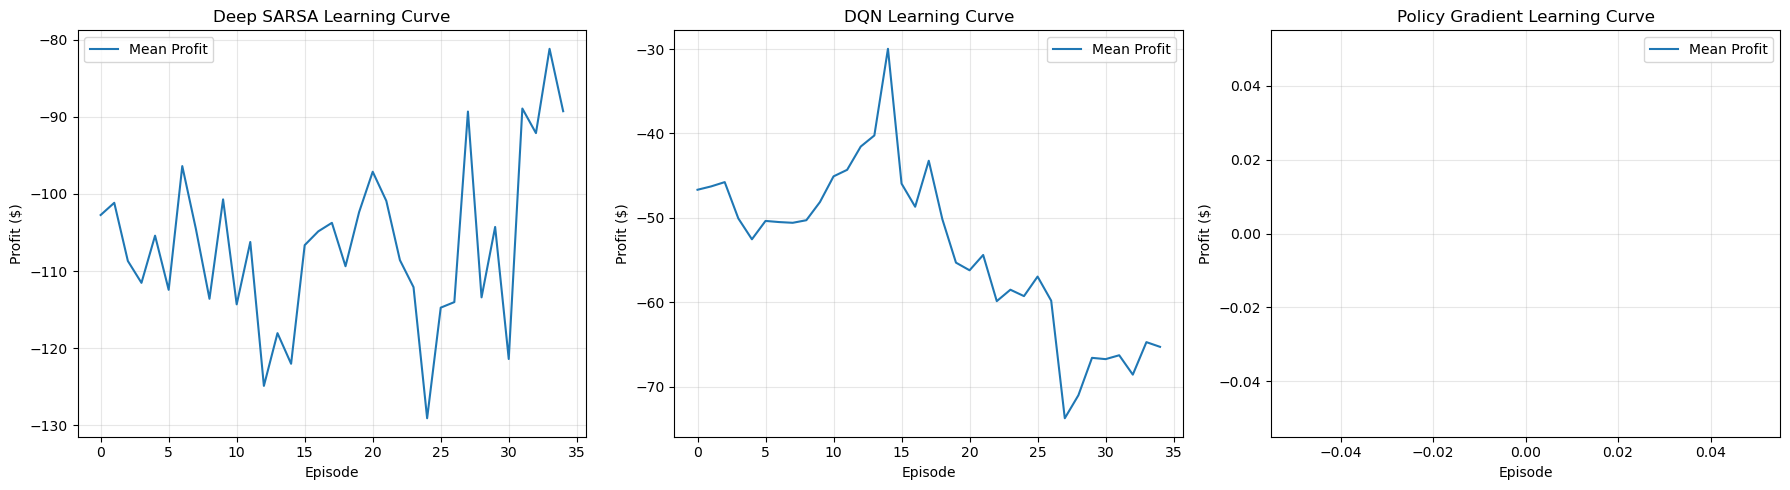


FINAL RESULTS SUMMARY

Deep SARSA:
  • Average Final Profit: $-89.27 ± $133.91
  • Best Profit: $129.65
  • Worst Profit: $-371.74
  • Peak Training Profit: $-81.17
  • ROI: -8.93%
  • Annual Return Rate: -4.61%
  • Total Return Rate: -8.93%

DQN:
  • Average Final Profit: $-65.27 ± $90.79
  • Best Profit: $0.00
  • Worst Profit: $-267.23
  • Peak Training Profit: $-29.98
  • ROI: -6.53%
  • Annual Return Rate: -3.35%
  • Total Return Rate: -6.53%

Policy Gradient:
  • Average Final Profit: $-72.43 ± $123.49
  • Best Profit: $251.57
  • Worst Profit: $-258.92
  • ROI: -7.24%
  • Annual Return Rate: -3.72%
  • Total Return Rate: -7.24%

Random Policy Baseline:
  • Average Profit: $799.92 ± $1127.57
  • Annual Return Rate: 34.52%
  • Total Return Rate: 79.99%


In [18]:
# Thêm đường dẫn gốc để import module
import sys
sys.path.append('d:\\NCKH\\SARSA_FinancialRL')

# Import run_experiments từ agents.run
from agents.run import run_experiments

# Định nghĩa shared_config với original settings từ paper, chỉnh nhẹ epsilon_decay xuống 0.95 để phù hợp với FPT data


# Chuyển lại Good Period
train = bad_train_HPG
test = bad_test_HPG

# Chạy thử nghiệm cho agent được bật với cùng siêu tham số
results = run_experiments(mdp, train, test, shared_config, num_runs=20)
results_good = results.copy()

# Hiển thị kết quả
import matplotlib.pyplot as plt

# Vẽ learning curves cho từng agent
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

agents = ['sarsa', 'dqn', 'pg']
titles = ['Deep SARSA', 'DQN', 'Policy Gradient']

for i, (agent, title) in enumerate(zip(agents, titles)):
    if agent in results:
        res = results[agent]
        mean_curve = res['learning_curve']
        
        axes[i].plot(mean_curve, label='Mean Profit')
        axes[i].set_title(f'{title} Learning Curve')
        axes[i].set_xlabel('Episode')
        axes[i].set_ylabel('Profit ($)')
        axes[i].legend()
        axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Định nghĩa hàm tính Annual Return Rate
def agent_annual_return(initial_capital, final_portfolio, start_date, end_date):
    total_return = (final_portfolio / initial_capital) - 1
    years = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days / 365.25
    if years <= 0: return 0, 0
    annual = (1 + total_return) ** (1 / years) - 1
    return annual * 100, total_return * 100

# Xác định start_date và end_date từ test_series
start_date = test.iloc[0]['time']
end_date = test.iloc[-1]['time']

# In tóm tắt kết quả
print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)

for agent in agents:
    if agent in results:
        res = results[agent]
        print(f"\n{res['agent']}:")
        print(f"  • Average Final Profit: ${res['final_profit']:.2f} ± ${res['std_final_profit']:.2f}")
        print(f"  • Best Profit: ${np.max(res['all_final_profits']):.2f}")
        print(f"  • Worst Profit: ${np.min(res['all_final_profits']):.2f}")
        if len(res['learning_curve']) > 0:
            print(f"  • Peak Training Profit: ${np.max(res['learning_curve']):.2f}")
        
        print(f"  • ROI: {res['roi']:.2f}%")
        
        # Tính Annual Return Rate
        final_portfolio = 1000 + res['final_profit']
        annual_rate, total_rate = agent_annual_return(1000, final_portfolio, start_date, end_date)
        print(f"  • Annual Return Rate: {annual_rate:.2f}%")
        print(f"  • Total Return Rate: {total_rate:.2f}%")

# So sánh với baseline (random policy)
print(f"\nRandom Policy Baseline:")
print(f"  • Average Profit: ${np.mean(profits):.2f} ± ${np.std(profits):.2f}")

# Tính Annual Return Rate cho baseline
baseline_final_portfolio = 1000 + np.mean(profits)
baseline_annual_rate, baseline_total_rate = agent_annual_return(1000, baseline_final_portfolio, start_date, end_date)
print(f"  • Annual Return Rate: {baseline_annual_rate:.2f}%")
print(f"  • Total Return Rate: {baseline_total_rate:.2f}%")

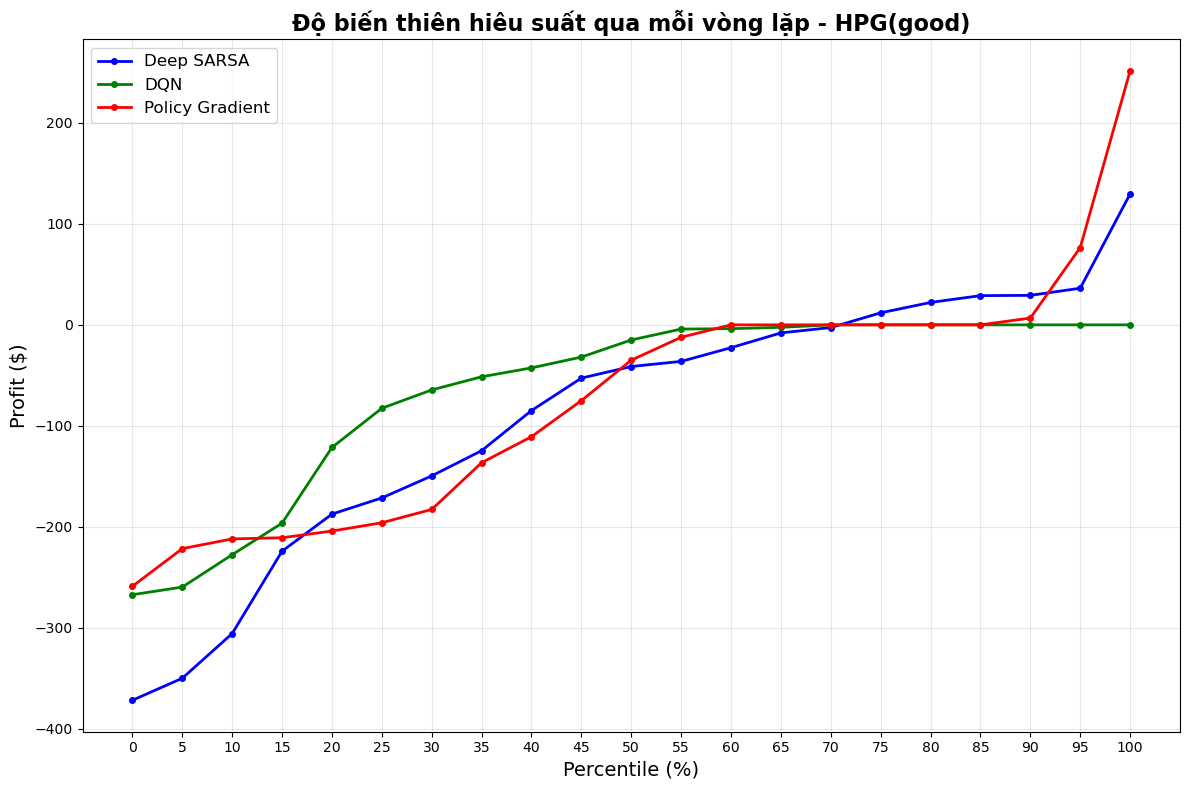

In [19]:
# Vẽ biểu đồ Percentiles Over Repeated Experiments
import matplotlib.pyplot as plt
import numpy as np

# Danh sách percentiles để vẽ (từ 0% đến 100% với bước 5%)
percentile_levels = np.arange(0, 101, 5)

# Tạo figure
plt.figure(figsize=(12, 8))

# Vẽ cho từng agent
colors = ['blue', 'green', 'red']
agents = ['sarsa', 'dqn', 'pg']
agent_names = ['Deep SARSA', 'DQN', 'Policy Gradient']

for i, (agent, name) in enumerate(zip(agents, agent_names)):
    if agent in results:
        profits = results[agent]['all_final_profits']
        sorted_profits = np.sort(profits)
        percentile_values = np.percentile(sorted_profits, percentile_levels)
        plt.plot(percentile_levels, percentile_values, 
                color=colors[i], marker='o', linestyle='-', 
                label=name, linewidth=2, markersize=4)

# Thiết lập biểu đồ
plt.title('Độ biến thiên hiêu suất qua mỗi vòng lặp - HPG(good)', fontsize=16, fontweight='bold')
plt.xlabel('Percentile (%)', fontsize=14)
plt.ylabel('Profit ($)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(percentile_levels)
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

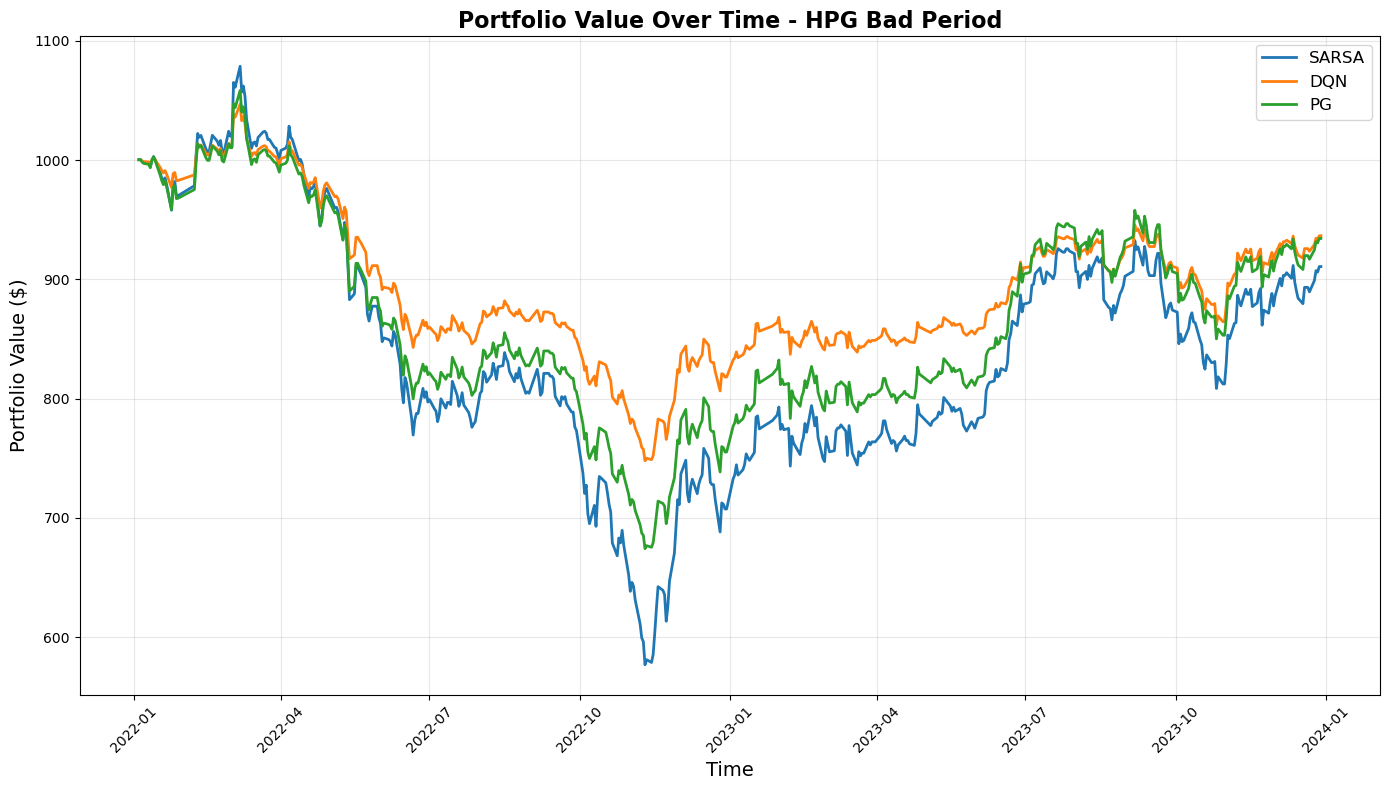

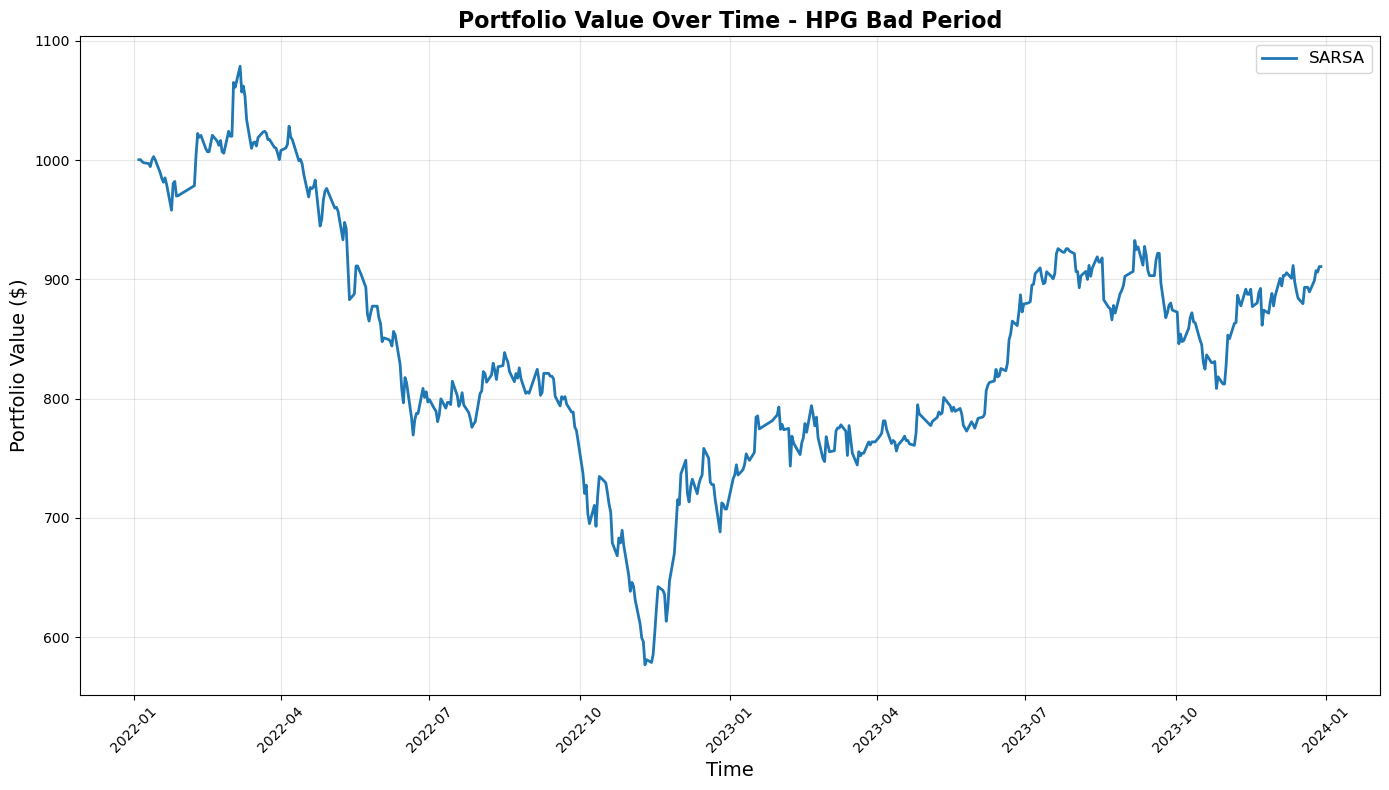

In [20]:
# Vẽ đồ thị
portfolio_histories = {}
for agent_name in ['sarsa', 'dqn', 'pg']:
    if agent_name in results:
        portfolio_histories[agent_name] = results[agent_name]['portfolio_history']

plt.figure(figsize=(14, 8))
for agent, port in portfolio_histories.items():
    # Cắt portfolio_history để khớp với len(test['time'])
    plt.plot(test['time'], port[1:], label=agent.upper(), linewidth=2)

plt.title('Portfolio Value Over Time - HPG Bad Period', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Portfolio Value ($)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Vẽ đồ thị
portfolio_histories = {}
for agent_name in ['sarsa']:
    if agent_name in results:
        portfolio_histories[agent_name] = results[agent_name]['portfolio_history']

plt.figure(figsize=(14, 8))
for agent, port in portfolio_histories.items():
    # Cắt portfolio_history để khớp với len(test['time'])
    plt.plot(test['time'], port[1:], label=agent.upper(), linewidth=2)

plt.title('Portfolio Value Over Time - HPG Bad Period', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Portfolio Value ($)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
import os

models_dir = r'D:\nckh\SARSA_FinancialRL\models'

os.makedirs(models_dir, exist_ok=True)

# Save trained models for FPT bad period
if 'sarsa' in results:
    torch.save(results['sarsa']['trained_agent'].state_dict(), os.path.join(models_dir, 'sarsa_bad_HPG.pth'))
    print("Deep SARSA model saved.")

if 'dqn' in results:
    results['dqn']['trained_agent'].save(os.path.join(models_dir, 'dqn_bad_HPG.pth'))
    print("DQN model saved.")

if 'pg' in results:
    results['pg']['trained_agent'].save_model(os.path.join(models_dir, 'pg_bad_HPG.pth'))
    print("Policy Gradient model saved.")

print("All models for HPG bad period saved successfully!")

Deep SARSA model saved.
DQN model saved.
Policy Gradient model saved.
All models for HPG bad period saved successfully!


In [ ]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.lib import colors
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Spacer, Image
from reportlab.lib.styles import getSampleStyleSheet
import os

# Đảm bảo thư mục tồn tại
results_dir = r'D:\nckh\SARSA_FinancialRL\application\results'
os.makedirs(results_dir, exist_ok=True)

# Tạo PDF
pdf_path = os.path.join(results_dir, 'HPG_bad.pdf')
doc = SimpleDocTemplate(pdf_path, pagesize=letter)
elements = []
styles = getSampleStyleSheet()

# Title
elements.append(Paragraph("Training Results for HPG Bad Period", styles['Title']))
elements.append(Spacer(1, 12))

# Hyperparameters
elements.append(Paragraph("Hyperparameters:", styles['Heading2']))
hp_text = f"""
Episodes: {shared_config['episodes']}
Gamma: {shared_config['gamma']}
Alpha: {shared_config['alpha']}
Epsilon Start: {shared_config['epsilon_start']}
Epsilon Min: {shared_config['epsilon_min']}
Epsilon Decay: {shared_config['epsilon_decay']}
NN Epochs: {shared_config['nn_epochs']}
NN LR: {shared_config['nn_lr']}
Enabled Agents: {shared_config['enabled_agents']}
"""
elements.append(Paragraph(hp_text, styles['Normal']))
elements.append(Spacer(1, 12))

# Results Table
elements.append(Paragraph("Training Results:", styles['Heading2']))

# Tạo data cho table
data = [['Agent', 'Average Final Profit', 'Best Profit', 'Worst Profit', 'Peak Training Profit', 'ROI', 'Annual Return Rate', 'Total Return Rate']]
for agent in agents:
    if agent in results:
        res = results[agent]
        avg_profit = f"${res['final_profit']:.2f} ± ${res['std_final_profit']:.2f}"
        best = f"${np.max(res['all_final_profits']):.2f}"
        worst = f"${np.min(res['all_final_profits']):.2f}"
        peak = f"${np.max(res['learning_curve']):.2f}" if len(res['learning_curve']) > 0 else 'N/A'
        roi = f"{res['roi']:.2f}%"
        final_portfolio = 1000 + res['final_profit']
        annual_rate, total_rate = agent_annual_return(1000, final_portfolio, start_date, end_date)
        annual = f"{annual_rate:.2f}%"
        total = f"{total_rate:.2f}%"
        data.append([res['agent'], avg_profit, best, worst, peak, roi, annual, total])

# Baseline
baseline_avg = f"${np.mean(profits):.2f} ± ${np.std(profits):.2f}"
baseline_final_portfolio = 1000 + np.mean(profits)
baseline_annual_rate, baseline_total_rate = agent_annual_return(1000, baseline_final_portfolio, start_date, end_date)
data.append(['Random Policy Baseline', baseline_avg, 'N/A', 'N/A', 'N/A', f"{((np.mean(profits)/1000)*100):.2f}%", f"{baseline_annual_rate:.2f}%", f"{baseline_total_rate:.2f}%"])

table = Table(data)
table.setStyle(TableStyle([
    ('BACKGROUND', (0,0), (-1,0), colors.grey),
    ('TEXTCOLOR', (0,0), (-1,0), colors.whitesmoke),
    ('ALIGN', (0,0), (-1,-1), 'CENTER'),
    ('FONTNAME', (0,0), (-1,0), 'Helvetica-Bold'),
    ('BOTTOMPADDING', (0,0), (-1,0), 12),
    ('BACKGROUND', (0,1), (-1,-1), colors.beige),
    ('GRID', (0,0), (-1,-1), 1, colors.black)
]))
elements.append(table)
elements.append(Spacer(1, 12))

# Biểu đồ Learning Curves
elements.append(Paragraph("Learning Curves:", styles['Heading2']))
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, (agent, title) in enumerate(zip(agents, titles)):
    if agent in results:
        res = results[agent]
        mean_curve = res['learning_curve']
        axes[i].plot(mean_curve, label='Mean Profit')
        axes[i].set_title(f'{title} Learning Curve')
        axes[i].set_xlabel('Episode')
        axes[i].set_ylabel('Profit ($)')
        axes[i].legend()
        axes[i].grid(alpha=0.3)
plt.tight_layout()
learning_curve_path = os.path.join(results_dir, 'learning_curves.png')
plt.savefig(learning_curve_path)
plt.close()
elements.append(Image(learning_curve_path, width=500, height=300))

# Biểu đồ Percentiles
elements.append(Paragraph("Profit Percentiles:", styles['Heading2']))
agent_names = titles
plt.figure(figsize=(12, 8))
color_list = ['blue', 'green', 'red']
for i, (agent, name) in enumerate(zip(agents, agent_names)):
    if agent in results:
        agent_profits = results[agent]['all_final_profits']
        sorted_profits = np.sort(agent_profits)
        percentile_values = np.percentile(sorted_profits, percentile_levels)
        plt.plot(percentile_levels, percentile_values, color=color_list[i], marker='o', linestyle='-', label=name, linewidth=2, markersize=4)
plt.title('Độ biến thiên hiệu suất qua mỗi vòng lặp - FPT', fontsize=16, fontweight='bold')
plt.xlabel('Percentile (%)', fontsize=14)
plt.ylabel('Profit ($)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(percentile_levels)
plt.tight_layout()
percentile_path = os.path.join(results_dir, 'percentiles_HPG.png')
plt.savefig(percentile_path)
plt.close()
elements.append(Image(percentile_path, width=500, height=400))

# Biểu đồ Portfolio Value Over Time
elements.append(Paragraph("Portfolio Value Over Time:", styles['Heading2']))
portfolio_histories = {}
for agent_name in ['sarsa', 'dqn', 'pg']:
    if agent_name in results:
        portfolio_histories[agent_name] = results[agent_name]['portfolio_history']

plt.figure(figsize=(14, 8))
for agent, port in portfolio_histories.items():
    plt.plot(test['time'], port[1:], label=agent.upper(), linewidth=2)
plt.title('Portfolio Value Over Time - HPG Bad Period', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Portfolio Value ($)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
portfolio_path = os.path.join(results_dir, 'portfolio_value_acb_bad.png')
plt.savefig(portfolio_path)
plt.close()
elements.append(Image(portfolio_path, width=500, height=400))

# Build PDF
doc.build(elements)
print(f"PDF saved to {pdf_path}")

PDF saved to D:\nckh\SARSA_FinancialRL\application\results\HPG_bad.pdf


: 